# Installing Packages
The following packages need to be installed before running the code below
- torchsummary

In [3]:
!pip install torchsummary

# Imports
Importing necessary packages

In [0]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Dataset Preparation and Loading
The following steps are performed for preparing the dataset for the model.
- Downloading the MNIST dataset
- Visualizing the dataset and the data statistics
- Defining data transformations
- Splitting the dataset into train and validation set
- Creating data loader for train and validation set

## Data Visualization and Statistics
Let's see how our data looks like and what are the mean and standard deviation values of the dataset. This information will help us decide the transformations that can be used on the dataset.

Data Statistics:
 - Data Shape: (60000, 28, 28)
 - min: 0.0
 - max: 1.0
 - mean: 0.1307
 - std: 0.3081
 - var: 0.0949



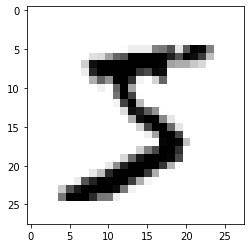

In [5]:
# Download data
sample_data = datasets.MNIST('./data', train=True, download=True).data

# Setti32ng the values in the data to be within the range [0, 1]
sample_data = sample_data.numpy() / 255

# Display some data statistics
print('Data Statistics:')
print(' - Data Shape:', sample_data.shape)
print(' - min:', np.min(sample_data))
print(' - max:', np.max(sample_data))
print(' - mean: %.4f' % np.mean(sample_data))
print(' - std: %.4f' % np.std(sample_data))
print(' - var: %.4f\n' % np.var(sample_data))

# Visualize a sample from the data
plt.imshow(sample_data[0], cmap='gray_r')

Let's view some more images. This will help in getting any ideas for data augmentation later on

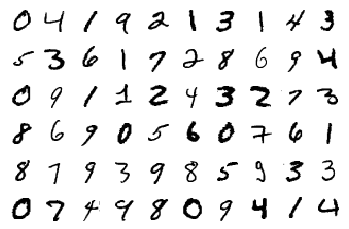

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(sample_data[index], cmap='gray_r')

## Data Transformations

The following transformations will be used
- ToTensor
- Normalize
- RandomRotation

In [0]:
# Train phase transformations
train_transforms = transforms.Compose([
    # Rotate image by 7 degrees
    transforms.RandomRotation((-6.0, 6.0), fill=(1,)),

    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation
    # these values were obtained from the data statistics above
    transforms.Normalize((0.1307,), (0.3081,))
])

# Validation phase transformations
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Train Data and Validation Data Split
The data is downloaded and split into two sets: train and validation

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
val = datasets.MNIST('./data', train=False, download=True, transform=val_transforms)

## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [9]:
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# validation dataloader
val_loader = torch.utils.data.DataLoader(val, **dataloader_args)

CUDA Available? True


# Model Architecture
Designing the model structure

In [0]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        dropout_rate = 0.01

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Parameters
Let's see the model summary

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1

# Model Training and Validation

Function for model training

In [0]:
def train(model, device, train_loader, optimizer, epoch, l1_factor):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch_ID={batch_idx} Accuracy={(100 * correct / processed):.2f}')

Function for model validation

In [0]:
def val(model, device, val_loader, losses, accuracies, incorrect_samples):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            img_batch = data  # This is done to keep data in CPU
            data, target = data.to(device), target.to(device)  # Get samples
            output = model(data)  # Get trained model output
            val_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            result = pred.eq(target.view_as(pred))

            # Save incorrect samples
            if len(incorrect_samples) < 25:
                for i in range(val_loader.batch_size):
                    if not list(result)[i]:
                        incorrect_samples.append({
                            'prediction': list(pred)[i],
                            'label': list(target.view_as(pred))[i],
                            'image': list(img_batch)[i]
                        })

            correct += result.sum().item()

    val_loss /= len(val_loader.dataset)
    losses.append(val_loss)
    accuracies.append(100. * correct / len(val_loader.dataset))

    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracies[-1]:.2f}%)\n')

Function for model execution

In [0]:
def run_model(l1=0.0, l2=0.0):
    losses = []
    accuracies = []
    incorrect_samples = []
    
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
    epochs = 40

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:')
        train(model, device, train_loader, optimizer, epoch, l1)
        scheduler.step()
        val(model, device, val_loader, losses, accuracies, incorrect_samples)
    
    return losses, accuracies, incorrect_samples

### Without L1 and L2 Regularization

In [16]:
loss, accuracy, incorrect_pred = run_model()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0700, Accuracy: 9850/10000 (98.50%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0699, Accuracy: 9819/10000 (98.19%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0499, Accuracy: 9868/10000 (98.68%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0378, Accuracy: 9899/10000 (98.99%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0304, Accuracy: 9926/10000 (99.26%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0265, Accuracy: 9930/10000 (99.30%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0247, Accuracy: 9943/10000 (99.43%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0240, Accuracy: 9939/10000 (99.39%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0238, Accuracy: 9939/10000 (99.39%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9945/10000 (99.45%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0229, Accuracy: 9940/10000 (99.40%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0245, Accuracy: 9939/10000 (99.39%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0226, Accuracy: 9943/10000 (99.43%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0229, Accuracy: 9942/10000 (99.42%)

Epoch 15:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0232, Accuracy: 9938/10000 (99.38%)

Epoch 16:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0226, Accuracy: 9941/10000 (99.41%)

Epoch 17:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0222, Accuracy: 9940/10000 (99.40%)

Epoch 18:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0234, Accuracy: 9942/10000 (99.42%)

Epoch 19:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0228, Accuracy: 9943/10000 (99.43%)

Epoch 20:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0222, Accuracy: 9946/10000 (99.46%)

Epoch 21:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0228, Accuracy: 9940/10000 (99.40%)

Epoch 22:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0225, Accuracy: 9940/10000 (99.40%)

Epoch 23:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0225, Accuracy: 9941/10000 (99.41%)

Epoch 24:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0235, Accuracy: 9938/10000 (99.38%)

Epoch 25:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0225, Accuracy: 9941/10000 (99.41%)

Epoch 26:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0231, Accuracy: 9944/10000 (99.44%)

Epoch 27:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9938/10000 (99.38%)

Epoch 28:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0224, Accuracy: 9941/10000 (99.41%)

Epoch 29:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0224, Accuracy: 9940/10000 (99.40%)

Epoch 30:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0221, Accuracy: 9940/10000 (99.40%)

Epoch 31:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0219, Accuracy: 9944/10000 (99.44%)

Epoch 32:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0216, Accuracy: 9939/10000 (99.39%)

Epoch 33:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0222, Accuracy: 9941/10000 (99.41%)

Epoch 34:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0220, Accuracy: 9941/10000 (99.41%)

Epoch 35:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0244, Accuracy: 9942/10000 (99.42%)

Epoch 36:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0229, Accuracy: 9941/10000 (99.41%)

Epoch 37:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0229, Accuracy: 9941/10000 (99.41%)

Epoch 38:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0227, Accuracy: 9941/10000 (99.41%)

Epoch 39:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0228, Accuracy: 9943/10000 (99.43%)

Epoch 40:


Loss=0.02 Batch_ID=937 Accuracy=99.12: 100%|██████████| 938/938 [00:21<00:00, 44.44it/s]



Validation set: Average loss: 0.0222, Accuracy: 9942/10000 (99.42%)



### With L1 Regularization

In [17]:
l1_loss, l1_accuracy, incorrect_pred_l1 = run_model(l1=0.001)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0926, Accuracy: 9815/10000 (98.15%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0958, Accuracy: 9747/10000 (97.47%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0827, Accuracy: 9768/10000 (97.68%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0657, Accuracy: 9839/10000 (98.39%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0819, Accuracy: 9772/10000 (97.72%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0333, Accuracy: 9920/10000 (99.20%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0350, Accuracy: 9908/10000 (99.08%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0373, Accuracy: 9913/10000 (99.13%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0398, Accuracy: 9890/10000 (98.90%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0399, Accuracy: 9894/10000 (98.94%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0253, Accuracy: 9929/10000 (99.29%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9934/10000 (99.34%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0251, Accuracy: 9932/10000 (99.32%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0267, Accuracy: 9927/10000 (99.27%)

Epoch 15:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0301, Accuracy: 9919/10000 (99.19%)

Epoch 16:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0241, Accuracy: 9938/10000 (99.38%)

Epoch 17:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

Epoch 18:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0242, Accuracy: 9936/10000 (99.36%)

Epoch 19:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0240, Accuracy: 9935/10000 (99.35%)

Epoch 20:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0247, Accuracy: 9935/10000 (99.35%)

Epoch 21:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0236, Accuracy: 9944/10000 (99.44%)

Epoch 22:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0232, Accuracy: 9939/10000 (99.39%)

Epoch 23:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0236, Accuracy: 9940/10000 (99.40%)

Epoch 24:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9933/10000 (99.33%)

Epoch 25:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0235, Accuracy: 9937/10000 (99.37%)

Epoch 26:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9936/10000 (99.36%)

Epoch 27:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0245, Accuracy: 9935/10000 (99.35%)

Epoch 28:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9934/10000 (99.34%)

Epoch 29:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9937/10000 (99.37%)

Epoch 30:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

Epoch 31:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9937/10000 (99.37%)

Epoch 32:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

Epoch 33:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9934/10000 (99.34%)

Epoch 34:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0237, Accuracy: 9934/10000 (99.34%)

Epoch 35:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0234, Accuracy: 9940/10000 (99.40%)

Epoch 36:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0237, Accuracy: 9935/10000 (99.35%)

Epoch 37:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0235, Accuracy: 9941/10000 (99.41%)

Epoch 38:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)

Epoch 39:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9938/10000 (99.38%)

Epoch 40:


Loss=0.21 Batch_ID=937 Accuracy=99.07: 100%|██████████| 938/938 [00:20<00:00, 45.87it/s]



Validation set: Average loss: 0.0237, Accuracy: 9939/10000 (99.39%)



### With L2 Regularization

In [18]:
l2_loss, l2_accuracy, incorrect_pred_l2 = run_model(l2=0.0001)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0838, Accuracy: 9804/10000 (98.04%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0539, Accuracy: 9869/10000 (98.69%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0420, Accuracy: 9898/10000 (98.98%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0372, Accuracy: 9890/10000 (98.90%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0339, Accuracy: 9903/10000 (99.03%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0248, Accuracy: 9932/10000 (99.32%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0253, Accuracy: 9930/10000 (99.30%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0242, Accuracy: 9934/10000 (99.34%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9933/10000 (99.33%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0237, Accuracy: 9932/10000 (99.32%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0242, Accuracy: 9929/10000 (99.29%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

Epoch 15:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

Epoch 16:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

Epoch 17:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

Epoch 18:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

Epoch 19:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)

Epoch 20:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9930/10000 (99.30%)

Epoch 21:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

Epoch 22:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

Epoch 23:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

Epoch 24:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9931/10000 (99.31%)

Epoch 25:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9931/10000 (99.31%)

Epoch 26:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)

Epoch 27:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

Epoch 28:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0236, Accuracy: 9935/10000 (99.35%)

Epoch 29:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

Epoch 30:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)

Epoch 31:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

Epoch 32:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

Epoch 33:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

Epoch 34:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

Epoch 35:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)

Epoch 36:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

Epoch 37:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

Epoch 38:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0233, Accuracy: 9935/10000 (99.35%)

Epoch 39:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

Epoch 40:


Loss=0.02 Batch_ID=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 50.39it/s]



Validation set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)



### With L1 and L2 Regularization

In [19]:
l1_l2_loss, l1_l2_accuracy, incorrect_pred_l1_l2 = run_model(l1=0.001, l2=0.0001)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.1525, Accuracy: 9679/10000 (96.79%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0929, Accuracy: 9792/10000 (97.92%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0797, Accuracy: 9785/10000 (97.85%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0759, Accuracy: 9819/10000 (98.19%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.1106, Accuracy: 9680/10000 (96.80%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0363, Accuracy: 9910/10000 (99.10%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0381, Accuracy: 9900/10000 (99.00%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0470, Accuracy: 9874/10000 (98.74%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0443, Accuracy: 9880/10000 (98.80%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0439, Accuracy: 9893/10000 (98.93%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0269, Accuracy: 9927/10000 (99.27%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0256, Accuracy: 9935/10000 (99.35%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0272, Accuracy: 9930/10000 (99.30%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0271, Accuracy: 9931/10000 (99.31%)

Epoch 15:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0286, Accuracy: 9930/10000 (99.30%)

Epoch 16:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0254, Accuracy: 9933/10000 (99.33%)

Epoch 17:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0250, Accuracy: 9936/10000 (99.36%)

Epoch 18:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0246, Accuracy: 9936/10000 (99.36%)

Epoch 19:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0245, Accuracy: 9938/10000 (99.38%)

Epoch 20:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0251, Accuracy: 9937/10000 (99.37%)

Epoch 21:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9939/10000 (99.39%)

Epoch 22:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0247, Accuracy: 9940/10000 (99.40%)

Epoch 23:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0247, Accuracy: 9939/10000 (99.39%)

Epoch 24:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9937/10000 (99.37%)

Epoch 25:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0236, Accuracy: 9938/10000 (99.38%)

Epoch 26:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9937/10000 (99.37%)

Epoch 27:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0246, Accuracy: 9935/10000 (99.35%)

Epoch 28:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0238, Accuracy: 9943/10000 (99.43%)

Epoch 29:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0241, Accuracy: 9941/10000 (99.41%)

Epoch 30:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0241, Accuracy: 9941/10000 (99.41%)

Epoch 31:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0247, Accuracy: 9936/10000 (99.36%)

Epoch 32:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0251, Accuracy: 9939/10000 (99.39%)

Epoch 33:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0243, Accuracy: 9941/10000 (99.41%)

Epoch 34:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0239, Accuracy: 9944/10000 (99.44%)

Epoch 35:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0245, Accuracy: 9940/10000 (99.40%)

Epoch 36:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0238, Accuracy: 9942/10000 (99.42%)

Epoch 37:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0240, Accuracy: 9938/10000 (99.38%)

Epoch 38:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0241, Accuracy: 9940/10000 (99.40%)

Epoch 39:


  0%|          | 0/938 [00:00<?, ?it/s]


Validation set: Average loss: 0.0241, Accuracy: 9939/10000 (99.39%)

Epoch 40:


Loss=0.22 Batch_ID=937 Accuracy=99.11: 100%|██████████| 938/938 [00:20<00:00, 45.23it/s]



Validation set: Average loss: 0.0245, Accuracy: 9936/10000 (99.36%)



## Plotting Results
Plotting changes in validation loss and accuracy obtained during model training in the following scenarios:
1. Without L1 and L2 regularization
2. With L1 regularization
3. With L2 regularization
4. With L1 and L2 regularization

In [0]:
def plot_metric(plain, l1, l2, l1_l2, metric):
    # Initialize a figure
    fig = plt.figure(figsize=(13, 11))

    # Plot values
    plain_plt, = plt.plot(plain)
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    l1_l2_plt, = plt.plot(l1_l2)

    # Set plot title
    plt.title(f'Validation {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if metric == 'Loss' else 'lower'
    plt.legend(
        (plain_plt, l1_plt, l2_plt, l1_l2_plt),
        ('Plain', 'L1', 'L2', 'L1 + L2'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 20}
    )

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')

Plot changes in validation loss

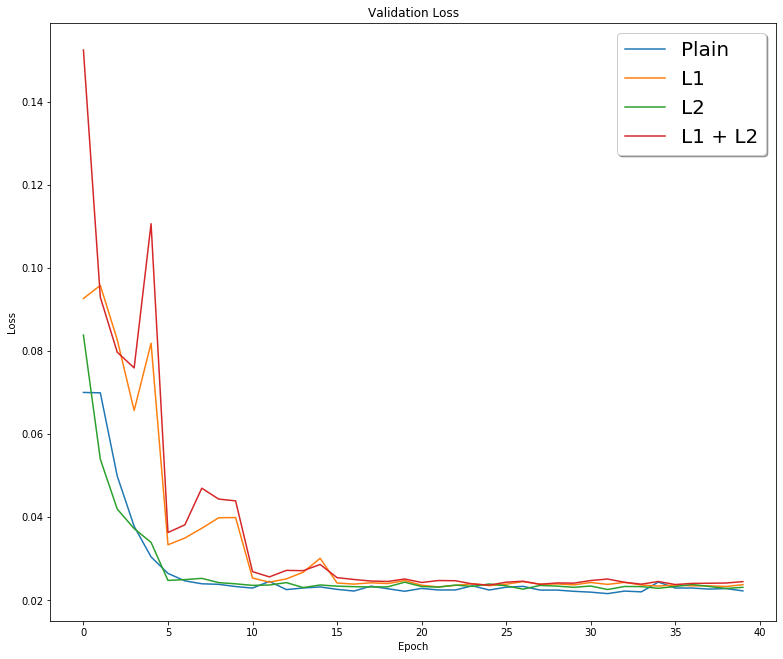

In [21]:
plot_metric(loss, l1_loss, l2_loss, l1_l2_loss, 'Loss')

Plot changes in validation accuracy

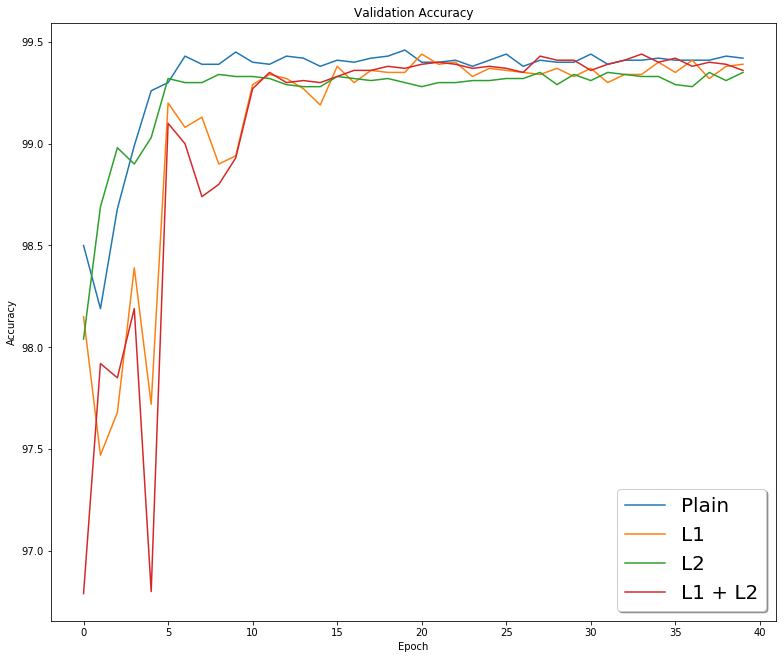

In [22]:
plot_metric(accuracy, l1_accuracy, l2_accuracy, l1_l2_accuracy, 'Accuracy')

## Display Results

Display 25 misclassified images for the following trained models:
1. Without L1 and L2 regularization
2. With L1 regularization
3. With L2 regularization
4. With L1 and L2 regularization

In [0]:
def save_and_show_result(data, metric):
    processed_data = []

    # Initialize plot
    row_count = -1
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    fig.tight_layout()

    for idx, result in enumerate(data):

        # If 25 samples have been stored, break out of loop
        if idx > 24:
            break
        
        label = result['label'].item()
        prediction = result['prediction'].item()
        image_name = f'{metric}/original/{metric}_{idx + 1}.png'
        save_image(result['image'], image_name)
        processed_data.append((image_name, label, prediction))

        # Plot image
        if idx % 5 == 0:
            row_count += 1
        axs[row_count][idx % 5].axis('off')
        axs[row_count][idx % 5].set_title(f'Label: {label}\nPrediction: {prediction}')
        axs[row_count][idx % 5].imshow(result['image'][0], cmap='gray_r')

        # Save each image in labelled format
        extent = axs[row_count][idx % 5].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'{metric}/labelled/{metric}_{idx + 1}.png', bbox_inches=extent.expanded(1.1, 1.5))
    
    # Save image
    fig.savefig(f'{metric}/{metric}_incorrect_predictions.png', bbox_inches='tight')

    # Save data
    df = pd.DataFrame(processed_data, columns=['Image', 'Label', 'Prediciton'])
    df.to_csv(f'{metric}/{metric}_incorrect_predictions.csv')

### Without L1 and L2 Regularization

  adding: plain/ (stored 0%)
  adding: plain/plain_incorrect_predictions.png (deflated 16%)
  adding: plain/plain_incorrect_predictions.csv (deflated 75%)
  adding: plain/original/ (stored 0%)
  adding: plain/original/plain_5.png (stored 0%)
  adding: plain/original/plain_21.png (stored 0%)
  adding: plain/original/plain_14.png (stored 0%)
  adding: plain/original/plain_24.png (stored 0%)
  adding: plain/original/plain_7.png (stored 0%)
  adding: plain/original/plain_23.png (stored 0%)
  adding: plain/original/plain_1.png (stored 0%)
  adding: plain/original/plain_6.png (stored 0%)
  adding: plain/original/plain_20.png (stored 0%)
  adding: plain/original/plain_3.png (stored 0%)
  adding: plain/original/plain_9.png (stored 0%)
  adding: plain/original/plain_18.png (stored 0%)
  adding: plain/original/plain_4.png (stored 0%)
  adding: plain/original/plain_8.png (stored 0%)
  adding: plain/original/plain_15.png (stored 0%)
  adding: plain/original/plain_13.png (stored 0%)
  adding: plain

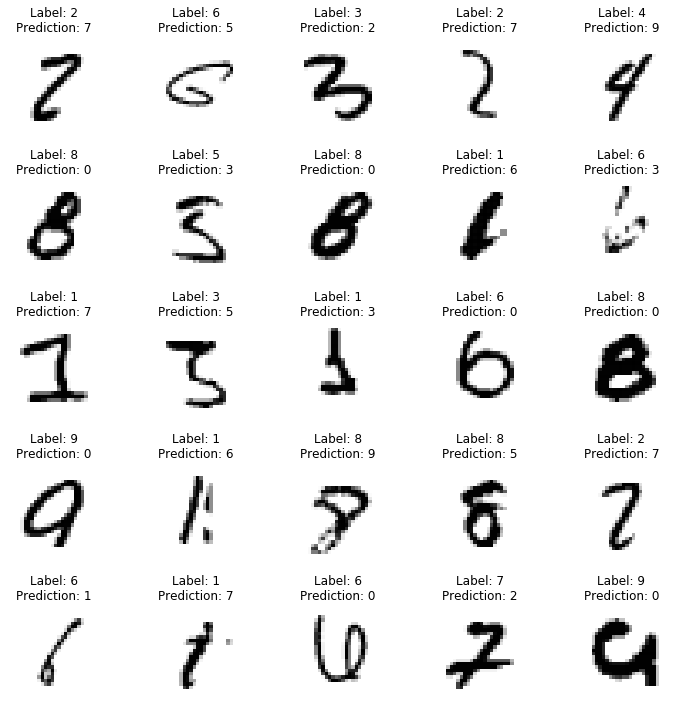

In [59]:
# Making directories
!mkdir plain
!mkdir plain/original
!mkdir plain/labelled

save_and_show_result(incorrect_pred, 'plain')

# For downloading the results
!zip -r plain.zip plain

### With L1 Regularization

  adding: l1/ (stored 0%)
  adding: l1/l1_incorrect_predictions.png (deflated 15%)
  adding: l1/original/ (stored 0%)
  adding: l1/original/l1_23.png (stored 0%)
  adding: l1/original/l1_2.png (stored 0%)
  adding: l1/original/l1_5.png (stored 0%)
  adding: l1/original/l1_12.png (stored 0%)
  adding: l1/original/l1_22.png (stored 0%)
  adding: l1/original/l1_15.png (stored 0%)
  adding: l1/original/l1_21.png (stored 0%)
  adding: l1/original/l1_16.png (stored 0%)
  adding: l1/original/l1_8.png (stored 0%)
  adding: l1/original/l1_3.png (stored 0%)
  adding: l1/original/l1_25.png (stored 0%)
  adding: l1/original/l1_1.png (stored 0%)
  adding: l1/original/l1_13.png (stored 0%)
  adding: l1/original/l1_6.png (stored 0%)
  adding: l1/original/l1_17.png (stored 0%)
  adding: l1/original/l1_4.png (stored 0%)
  adding: l1/original/l1_10.png (stored 0%)
  adding: l1/original/l1_24.png (stored 0%)
  adding: l1/original/l1_11.png (stored 0%)
  adding: l1/original/l1_9.png (stored 0%)
  adding: 

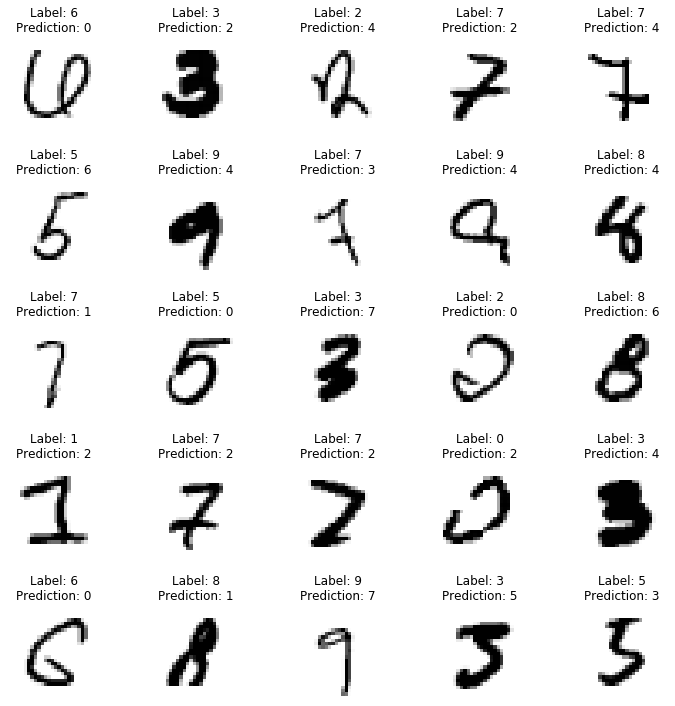

In [60]:
# Making directories
!mkdir l1
!mkdir l1/original
!mkdir l1/labelled

save_and_show_result(incorrect_pred_l1, 'l1')

# For downloading the results
!zip -r l1.zip l1

### With L2 Regularization

  adding: l2/ (stored 0%)
  adding: l2/original/ (stored 0%)
  adding: l2/original/l2_2.png (stored 0%)
  adding: l2/original/l2_10.png (stored 0%)
  adding: l2/original/l2_7.png (stored 0%)
  adding: l2/original/l2_4.png (stored 0%)
  adding: l2/original/l2_9.png (stored 0%)
  adding: l2/original/l2_11.png (stored 0%)
  adding: l2/original/l2_19.png (stored 0%)
  adding: l2/original/l2_1.png (stored 0%)
  adding: l2/original/l2_18.png (stored 0%)
  adding: l2/original/l2_13.png (stored 0%)
  adding: l2/original/l2_15.png (stored 0%)
  adding: l2/original/l2_3.png (stored 0%)
  adding: l2/original/l2_20.png (stored 0%)
  adding: l2/original/l2_16.png (stored 0%)
  adding: l2/original/l2_8.png (stored 0%)
  adding: l2/original/l2_17.png (stored 0%)
  adding: l2/original/l2_21.png (stored 0%)
  adding: l2/original/l2_22.png (stored 0%)
  adding: l2/original/l2_12.png (stored 0%)
  adding: l2/original/l2_23.png (stored 0%)
  adding: l2/original/l2_24.png (stored 0%)
  adding: l2/original/

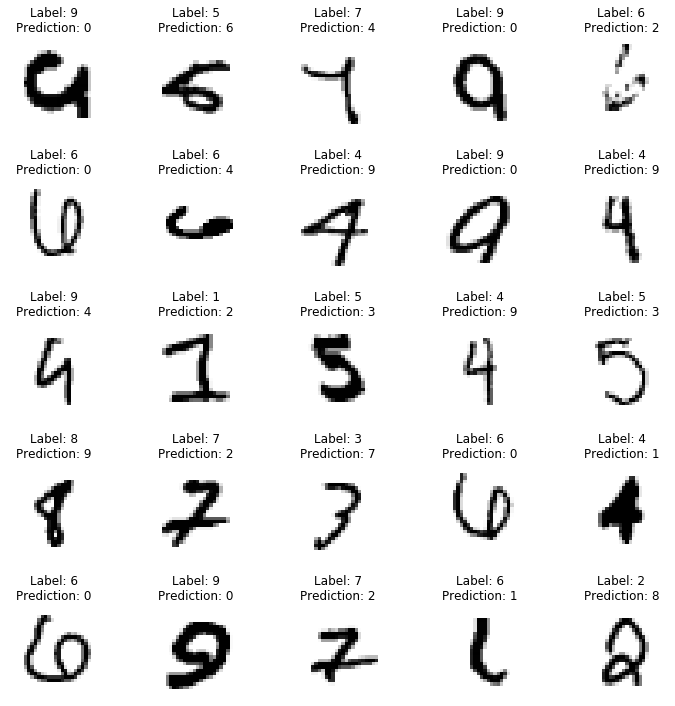

In [61]:
# Making directories
!mkdir l2
!mkdir l2/original
!mkdir l2/labelled

save_and_show_result(incorrect_pred_l2, 'l2')

# For downloading the results
!zip -r l2.zip l2

### With L1 and L2 Regularization

  adding: l1_l2/ (stored 0%)
  adding: l1_l2/original/ (stored 0%)
  adding: l1_l2/original/l1_l2_3.png (deflated 0%)
  adding: l1_l2/original/l1_l2_20.png (stored 0%)
  adding: l1_l2/original/l1_l2_8.png (stored 0%)
  adding: l1_l2/original/l1_l2_14.png (stored 0%)
  adding: l1_l2/original/l1_l2_7.png (stored 0%)
  adding: l1_l2/original/l1_l2_9.png (stored 0%)
  adding: l1_l2/original/l1_l2_22.png (stored 0%)
  adding: l1_l2/original/l1_l2_17.png (stored 0%)
  adding: l1_l2/original/l1_l2_2.png (stored 0%)
  adding: l1_l2/original/l1_l2_15.png (stored 0%)
  adding: l1_l2/original/l1_l2_19.png (stored 0%)
  adding: l1_l2/original/l1_l2_13.png (stored 0%)
  adding: l1_l2/original/l1_l2_4.png (stored 0%)
  adding: l1_l2/original/l1_l2_1.png (stored 0%)
  adding: l1_l2/original/l1_l2_21.png (stored 0%)
  adding: l1_l2/original/l1_l2_6.png (stored 0%)
  adding: l1_l2/original/l1_l2_16.png (stored 0%)
  adding: l1_l2/original/l1_l2_18.png (stored 0%)
  adding: l1_l2/original/l1_l2_25.png (

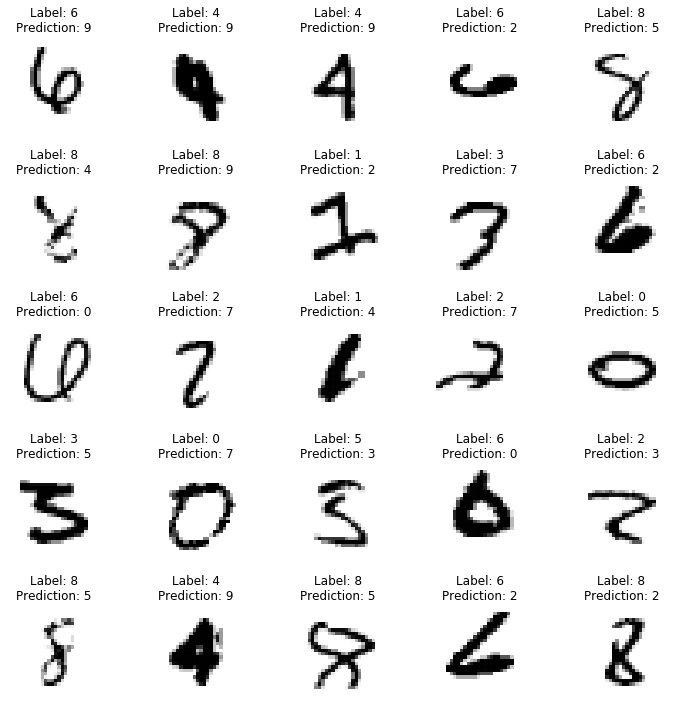

In [62]:
# Making directories
!mkdir l1_l2
!mkdir l1_l2/original
!mkdir l1_l2/labelled

save_and_show_result(incorrect_pred_l1_l2, 'l1_l2')

# For downloading the results
!zip -r l1_l2.zip l1_l2